### MNIST 손글씨 예측하기

In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else'cpu') #GPU기반의 지원 팩
device

device(type='cuda')

### 하이퍼파라미터, DataLoader

In [37]:
input_size = 784  #28*28*1 MNIST 사이즈
hidden_size = 500 #hiddenLayer unit의 개수
num_classes = 10 #최종적으로 10가 출력
num_epochs = 5
batch_size = 100
learning_rate = 0.01

In [38]:
train_dataset= torchvision.datasets.MNIST(root='../../data/',
                           train = True,
                           transform = transforms.ToTensor(),
                           download = True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False,
                                          transform=transforms.ToTensor()) #download는 한번만 해주면 됨 train에서 해줬으면 test에서 따로 안해줘도 사용 가능하다.

'''
2단계에 걸쳐서 데이타셋을 로딩해온다.
DataLoader 내부적으로 멀티쓰레딩 방식으로 랩핑되어 있어서 클래스를 빠르게 로더
한번 할 때 마다, 앞에서 정해준 것 처럼 100개씩 로딩한다.
이 때, shuffle = True하게 되면 로딩할 때 마다, 데이타의 순서를 바꿔서
모델이 답지를 외우는 것을 방지하는 효과를 가지고 있다.
Test때는 필요 없음.
'''
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle = False)


### 모델 생성하기 -- Fully Connected Network

In [39]:
class NeuralNet(nn.Module):
  def __init__(self,input_size,hidden_size,num_classes):
    super(NeuralNet,self).__init__()
    self.fc1 = nn.Linear(input_size,hidden_size)
    self.relu = nn.ReLU() # 활성화 함수
    self.fc2 = nn.Linear(hidden_size,num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)

    return out

### 인스턴스화

In [41]:
model = NeuralNet(input_size,hidden_size,num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

total_step = len(train_loader) #600

for epoch in range(num_epochs): #5번
  for i,(images,labels) in enumerate(train_loader): #100개씩 train_loader에 있는 이미지와 라벨을 묶어서 반환 #한번 돌 때 마다 100장씩 로딩한다.
    images = images.reshape(-1,28*28).to(device) #-1? 28*28외의 정보를 -1에 다 넣음.펼치는 행위
    labels = labels.to(device)

    #forwarding
    preds = model(images)
    loss = loss_function(preds,labels) #두 라벨을 비교

    #Backward
    optimizer.zero_grad() #optimizer 초기화 무조건 써야함!
    loss.backward() #각각의 weight들이 loss에 대해서 얼마나 책임을 져야하는지?
    optimizer.step() # 실질적인 weight들의 업데이트가 진행된다.. 학습

    #Epoch이 진행됨에 따라 얼마나 loss가 줄어드는지만 확인하면 됨
    if (i+1)%100==0:
      print('Epoch [{}/{}], Step[{}/{}], Loss: {:.3f}'.format(epoch+1,num_epochs,i+1,total_step,loss.item()))


Epoch [1/5], Step[100/600], Loss: 0.128
Epoch [1/5], Step[200/600], Loss: 0.218
Epoch [1/5], Step[300/600], Loss: 0.309
Epoch [1/5], Step[400/600], Loss: 0.140
Epoch [1/5], Step[500/600], Loss: 0.280
Epoch [1/5], Step[600/600], Loss: 0.059
Epoch [2/5], Step[100/600], Loss: 0.049
Epoch [2/5], Step[200/600], Loss: 0.049
Epoch [2/5], Step[300/600], Loss: 0.488
Epoch [2/5], Step[400/600], Loss: 0.103
Epoch [2/5], Step[500/600], Loss: 0.106
Epoch [2/5], Step[600/600], Loss: 0.128
Epoch [3/5], Step[100/600], Loss: 0.026
Epoch [3/5], Step[200/600], Loss: 0.146
Epoch [3/5], Step[300/600], Loss: 0.113
Epoch [3/5], Step[400/600], Loss: 0.153
Epoch [3/5], Step[500/600], Loss: 0.126
Epoch [3/5], Step[600/600], Loss: 0.056
Epoch [4/5], Step[100/600], Loss: 0.098
Epoch [4/5], Step[200/600], Loss: 0.003
Epoch [4/5], Step[300/600], Loss: 0.139
Epoch [4/5], Step[400/600], Loss: 0.037
Epoch [4/5], Step[500/600], Loss: 0.035
Epoch [4/5], Step[600/600], Loss: 0.185
Epoch [5/5], Step[100/600], Loss: 0.084


### Model Test

In [68]:
'''
with torch.no_grad():
  some code
-> code부분에서 gradient를 사용하지 않겠다. == backpropargation 안쓰겠다.

with torch.grad_enabled(False):
  some code
위와 동일한 코드임

기본적으로 Backpropargation은 *'학 습'*에 있어서 필수이다.
메모리적인 부분에서 봤을 때, 이 부분이 동작할 수 있도록 메모리를 훨씬 더 많이 할당함
이걸 해주면 메모리를 따로 빼는 부분을 생략한다 그렇기 때문에 하는 것과 하지 않는 것의 퍼포먼스 차이가 큼
FCN -- 1차원으로 주욱 늘린다.  <-> CNN은 늘리지 않음 속도는 CNN이 10~100배 빠름. 그렇기 때문에 FCN으로 작업한 것은 성능적으로 CPU에서 돌아가지 못한다.
그래서 돌리고 싶으면 GPU로 돌려야함
FCN은 초창기 모델이라 잘 사용하지 않고, 부분적으로 사용한다(CNN에서 사용하는데 CNN에서 여러가지 기법을 사용한 뒤 맨 마지막에 FCN으로 output을 분류함.)
'''

with torch.no_grad(): # no_grad는 학습할 필요가 없을 때 넣어주는 것(== Backward 하지 않음 == (편)미분 안함)
  correct = 0
  total = 0
  
  for images,labels in test_loader:
    images = images.reshape(-1,28*28).to(device) #안하면 에러 imges.reshpae(-1,784)형태로 넣어도 됨
    labels = labels.to(device)
    
    outputs = model(images)
    
    #값을 찾을 때 벨류와 인덱스를 함께 리턴해야함, 근데 인덱스==라벨인 경우가 있음
    #이런 경우 항상쓰던 entropy나 MSE를 사용하지 않는다.( 다양한 방법이 있다는 소리 )

    _,predicted = torch.max(outputs.data,1) #max는 두개의 값을 return 함 -> 80,3 근데 80 안필요해서 앞에 거 버리기위해 _를 씀 (return되나, 사용하지 않는다.)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print('Accuracy of Fully Connected Networks images: {}%'.format(100* correct/total))

#모델 저장
  torch.save(model.state_dict(),'model.ckpt') #모델의 weight와 bias(모델의 학습대상)을 저장한다.

Accuracy of Fully Connected Networks images: 97.11%


In [44]:
images.shape

torch.Size([100, 784])

tensor(2, device='cuda:0')


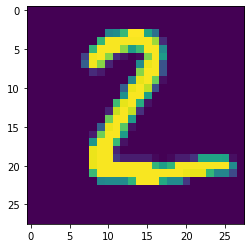

In [57]:
plt.imshow(images[1].cpu().reshape(28,28)) #cpu로 바꾸고 하나로 늘렸던 이미지를 원래 형태로 돌려줘야함

print(outputs[1].argmax())

In [58]:
outputs.shape

torch.Size([100, 10])

tensor(7, device='cuda:0')
tensor(2, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(4, device='cuda:0')
tensor(1, device='cuda:0')
tensor(4, device='cuda:0')
tensor(9, device='cuda:0')
tensor(5, device='cuda:0')
tensor(9, device='cuda:0')


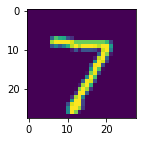

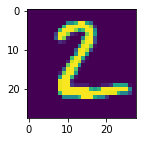

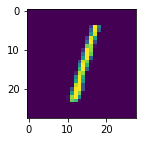

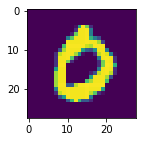

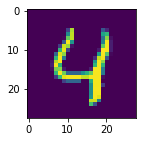

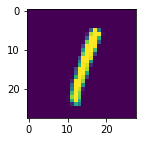

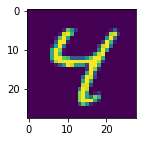

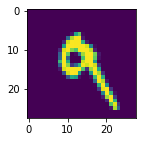

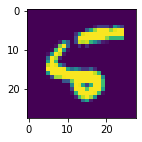

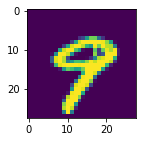

In [65]:
for i in range(10):
  plt.figure(figsize=(2,2))
  plt.imshow(images[i].cpu().reshape(28,28))
  print(outputs[i].argmax())